In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip uninstall pandas scikit-learn -y
!pip install pandas scikit-learn

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


Using device: cuda
Loading data...
Building vocabulary...
Vocabulary size: 2759
Domains: ['mobile', 'fashion', 'cosmetic', 'app']
Number of classes: 4
Initializing model...
Starting training...
Epoch 1/20
  Train Loss: 0.6563, Train Acc: 0.7509
  Dev Loss: 0.4126, Dev Acc: 0.8504
  -> Best model saved!
Epoch 2/20
  Train Loss: 0.3503, Train Acc: 0.8765
  Dev Loss: 0.3784, Dev Acc: 0.8650
  -> Best model saved!
Epoch 3/20
  Train Loss: 0.2739, Train Acc: 0.9043
  Dev Loss: 0.3926, Dev Acc: 0.8832
  -> Best model saved!
Epoch 4/20
  Train Loss: 0.2356, Train Acc: 0.9168
  Dev Loss: 0.4062, Dev Acc: 0.8723
Epoch 5/20
  Train Loss: 0.2118, Train Acc: 0.9225
  Dev Loss: 0.3700, Dev Acc: 0.8887
  -> Best model saved!
Epoch 6/20
  Train Loss: 0.1940, Train Acc: 0.9280
  Dev Loss: 0.3817, Dev Acc: 0.8850
Epoch 7/20
  Train Loss: 0.1747, Train Acc: 0.9341
  Dev Loss: 0.4201, Dev Acc: 0.8814
Epoch 8/20
  Train Loss: 0.1584, Train Acc: 0.9394
  Dev Loss: 0.3747, Dev Acc: 0.8796
Epoch 9/20
  Train

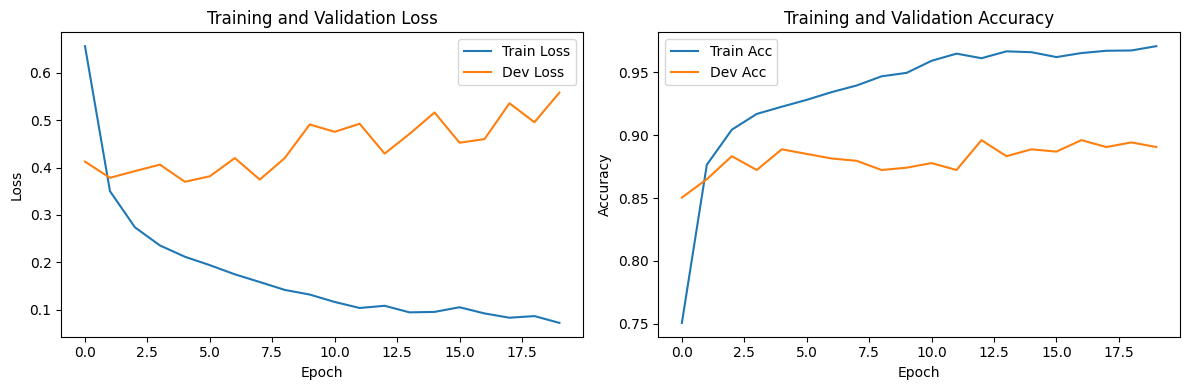

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from collections import Counter
import math
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ============== 1. POSITIONAL ENCODING ==============
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# ============== 2. MULTI-HEAD ATTENTION ==============
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output, _ = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        return output

# ============== 3. FEED FORWARD NETWORK ==============
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

# ============== 4. ENCODER LAYER ==============
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# ============== 5. TRANSFORMER ENCODER ==============
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_classes, max_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        self.d_model = d_model

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, mask)

        # Global average pooling
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# ============== 6. DATASET ==============
class ViOCDDataset(Dataset):
    def __init__(self, data, word2idx, max_len):
        self.data = data
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item['review'].lower().split()

        # Convert to indices
        indices = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

        # Padding/Truncating
        if len(indices) < self.max_len:
            indices += [self.word2idx['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(item['label_id'], dtype=torch.long)

# ============== 7. LOAD DATA ==============
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return [data[key] for key in data.keys()]

# ============== 8. BUILD VOCABULARY ==============
def build_vocab(train_data, min_freq=2):
    word_counts = Counter()
    for item in train_data:
        tokens = item['review'].lower().split()
        word_counts.update(tokens)

    vocab = ['<PAD>', '<UNK>']
    vocab += [word for word, count in word_counts.items() if count >= min_freq]

    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx, vocab

# ============== 9. TRAIN FUNCTION ==============
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

# ============== 10. EVALUATE FUNCTION ==============
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, all_preds, all_labels

# ============== 11. MAIN TRAINING ==============
def main():
    # Hyperparameters
    d_model = 256
    num_heads = 8
    d_ff = 1024
    num_layers = 3
    max_len = 128
    batch_size = 32
    num_epochs = 20
    learning_rate = 0.0001
    dropout = 0.1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    print("Loading data...")
    train_data = load_data('/content/drive/MyDrive/DATASET/UIT-ViOCD/train.json')
    dev_data = load_data('/content/drive/MyDrive/DATASET/UIT-ViOCD/dev.json')
    test_data = load_data('/content/drive/MyDrive/DATASET/UIT-ViOCD/test.json')

    # Build vocabulary
    print("Building vocabulary...")
    word2idx, vocab = build_vocab(train_data)
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Create domain mapping
    domains = list(set([item['domain'] for item in train_data]))
    domain2idx = {domain: idx for idx, domain in enumerate(domains)}
    idx2domain = {idx: domain for domain, idx in domain2idx.items()}
    num_classes = len(domains)

    # Add label_id to data
    for item in train_data:
        item['label_id'] = domain2idx[item['domain']]
    for item in dev_data:
        item['label_id'] = domain2idx[item['domain']]
    for item in test_data:
        item['label_id'] = domain2idx[item['domain']]

    print(f"Domains: {domains}")
    print(f"Number of classes: {num_classes}")

    # Create datasets
    train_dataset = ViOCDDataset(train_data, word2idx, max_len)
    dev_dataset = ViOCDDataset(dev_data, word2idx, max_len)
    test_dataset = ViOCDDataset(test_data, word2idx, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    print("Initializing model...")
    model = TransformerEncoder(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        num_classes=num_classes,
        max_len=max_len,
        dropout=dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    print("Starting training...")
    train_losses, dev_losses = [], []
    train_accs, dev_accs = [], []
    best_dev_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        dev_loss, dev_acc, _, _ = evaluate(model, dev_loader, criterion, device)

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        train_accs.append(train_acc)
        dev_accs.append(dev_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}")

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"  -> Best model saved!")

    # Load best model and evaluate on test set
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=domains))

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(dev_accs, label='Dev Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.tight_layout()
    plt.savefig('training_curves.png')
    print("\nTraining curves saved to 'training_curves.png'")

if __name__ == "__main__":
    main()